In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib widget
# %config InlineBackend.figure_format = "svg"
%config InlineBackend.figure_format = "retina"

import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams["text.usetex"] = False # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
command_file_name = "../data/western_north_america/basic_command.json"
command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

# Get elastic operators and TDE smoothing operators

In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)
celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

Calculating Okada partials for segments:   0%|          | 0/837 [00:00<?, ?it/s]

Calculating cutde partials for triangles:   0%|          | 0/1841 [00:00<?, ?it/s]

# Calculate non-elastic operators

In [5]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(station)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(station)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(assembly, block, command)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(assembly, segment, block, command)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(segment, block)
operators.block_strain_rate_to_velocities, strain_rate_block_index = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(mogi, station, command)
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Plot input data

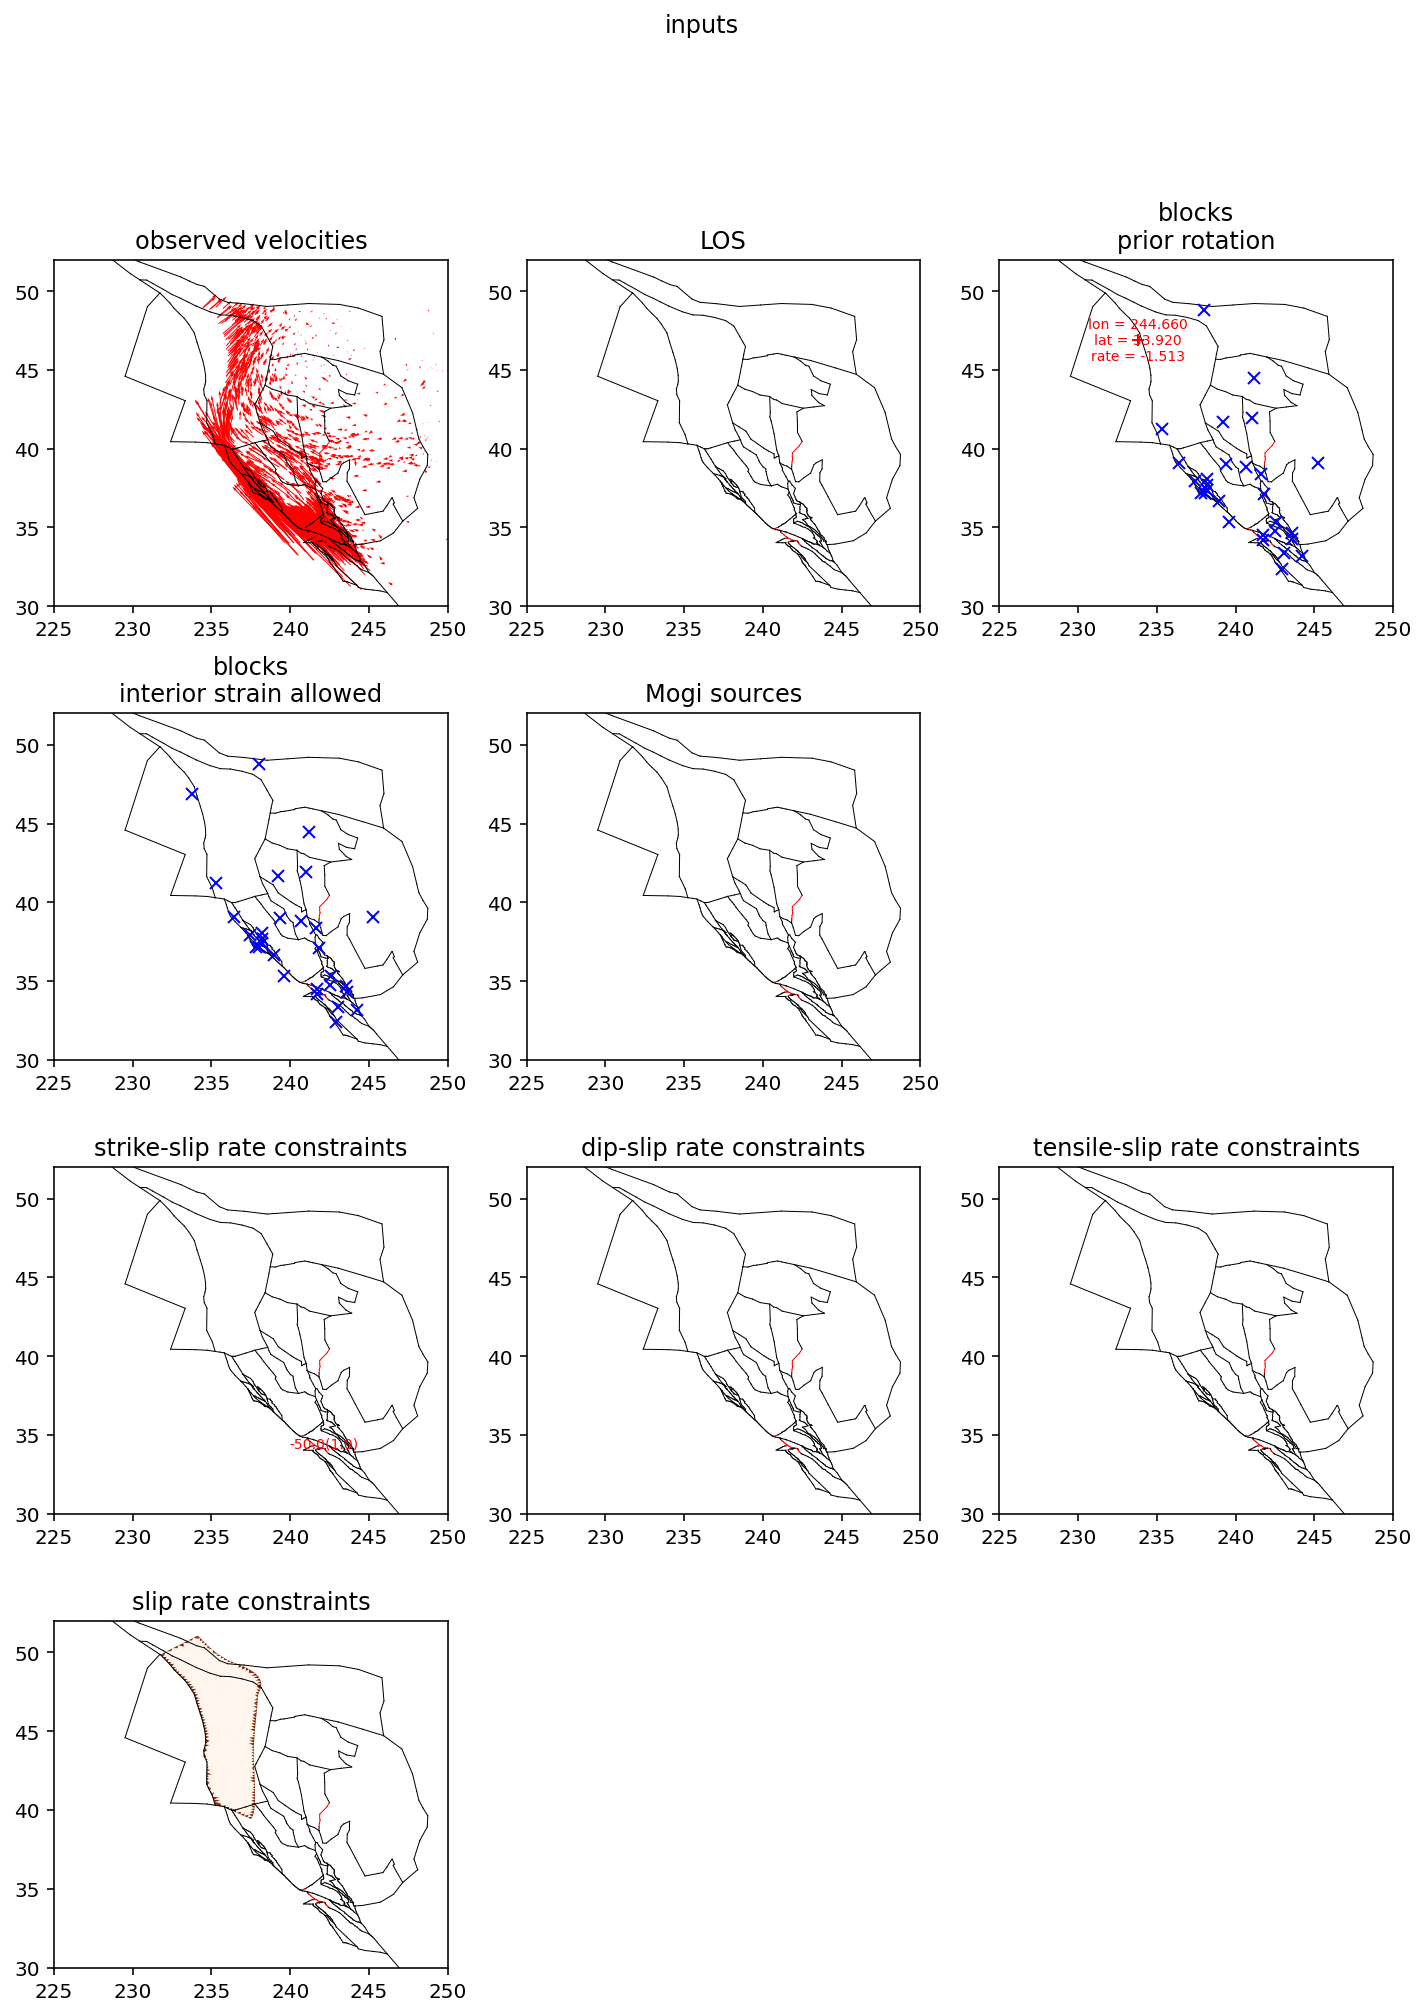

In [6]:
celeri.plot_input_summary(segment, station, block, meshes, mogi, sar, lon_range=(225, 250), lat_range=(30, 52), quiver_scale=1e2)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
\end{bmatrix}
$$

# Block model with block rotations, fully locked segments and partially locked subduction zone using the full tde_matrix and smoothing matrix

In [7]:
# TODO: What should this conversion be?
DEG_PER_MYR_TO_RAD_PER_YR = np.deg2rad(1) / 1e6
DEG_PER_MYR_TO_RAD_PER_YR = 1 / 1e6

# Create dictionary to store indices and sizes for operator building
index = addict.Dict()
index.n_stations = assembly.data.n_stations
index.vertical_velocities = np.arange(2, 3 * index.n_stations, 3)
index.n_blocks = len(block)
index.n_block_constraints = assembly.data.n_block_constraints
index.station_row_keep_index = celeri.get_keep_index_12(3 * len(station))
index.start_station_row = 0
index.end_station_row = 2 * len(station)
index.start_block_col = 0
index.end_block_col = 3 * len(block)
index.start_block_constraints_row = index.end_station_row
index.end_block_constraints_row = index.start_block_constraints_row + 3 * index.n_block_constraints
index.n_slip_rate_constraints = assembly.data.slip_rate_constraints.size
index.start_slip_rate_constraints_row = index.end_block_constraints_row
index.end_slip_rate_constraints_row = index.start_slip_rate_constraints_row + index.n_slip_rate_constraints

index.meshes = [addict.Dict()] * len(meshes)
index.n_tde_total = 0
index.n_tde_constraints_total = 0
for i in range(len(meshes)):
    index.meshes[i].n_tde = meshes[i].n_tde
    index.n_tde_total += index.meshes[i].n_tde
    index.meshes[i].n_tde_constraints = meshes[i].n_tde_constraints
    index.n_tde_constraints_total += index.meshes[i].n_tde_constraints
    if i == 0:
        index.meshes[i].start_tde_col = index.end_block_col
        index.meshes[i].end_tde_col = index.meshes[i].start_tde_col + 2 * index.meshes[i].n_tde
        index.meshes[i].start_tde_smoothing_row = index.end_slip_rate_constraints_row
        index.meshes[i].end_tde_smoothing_row = index.meshes[i].start_tde_smoothing_row + 2 * index.meshes[i].n_tde
        index.meshes[i].start_tde_constraint_row = index.meshes[i].end_tde_smoothing_row
        index.meshes[i].end_tde_constraint_row = index.meshes[i].start_tde_constraint_row + index.meshes[i].n_tde_constraints
    else:
        index.meshes[i].start_tde_col = index.meshes[i - 1].end_tde_col
        index.meshes[i].end_tde_col = index.meshes[i].start_tde_col + 2 * index.meshes[i].n_tde
        index.meshes[i].start_tde_smoothing_row = index.meshes[i - 1].end_tde_smoothing_row
        index.meshes[i].end_tde_smoothing_row = index.meshes[i].start_tde_smoothing_row + 2 * index.meshes[i].n_tde
        index.meshes[i].start_tde_constraint_row = index.meshes[i - 1].end_tde_smoothing_row
        index.meshes[i].end_tde_constraint_row = index.meshes[i].start_tde_constraint_row + index.meshes[i].n_tde_constraints


# Initialize data vector
estimation = addict.Dict()
estimation.data_vector = np.zeros(2 * index.n_stations + 3 * index.n_block_constraints + index.n_slip_rate_constraints + 2 * index.n_tde_total + index.n_tde_constraints_total)

# Add GPS stations to data vector
estimation.data_vector[index.start_station_row:index.end_station_row] = celeri.interleave2(assembly.data.east_vel, assembly.data.north_vel)

# Add block motion constraints to data vector
estimation.data_vector[index.start_block_constraints_row:index.end_block_constraints_row] = DEG_PER_MYR_TO_RAD_PER_YR * assembly.data.block_constraints

# Add slip rate constraints to data vector
estimation.data_vector[index.start_slip_rate_constraints_row:index.end_slip_rate_constraints_row] = assembly.data.slip_rate_constraints

# Initialize and build weighting matrix
estimation.weighting_vector = np.ones(2 * index.n_stations + 3 * index.n_block_constraints + index.n_slip_rate_constraints + 2 * index.n_tde_total + index.n_tde_constraints_total)
estimation.weighting_vector[index.start_station_row:index.end_station_row] = celeri.interleave2(1 / (station.east_sig ** 2), 1 / (station.north_sig ** 2))
estimation.weighting_vector[index.start_block_constraints_row:index.end_block_constraints_row] = 1.0
estimation.weighting_vector[index.start_slip_rate_constraints_row:index.end_slip_rate_constraints_row] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

# Initialize linear operator
estimation.operator = np.zeros((2 * index.n_stations + 3 * index.n_block_constraints + index.n_slip_rate_constraints + 2 * index.n_tde_total + index.n_tde_constraints_total,
                                3 * index.n_blocks + 2 * index.n_tde_total))

# Insert block rotations and elastic velocities from fully locked segments
operators.rotation_to_slip_rate_to_okada_to_velocities = operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
estimation.operator[index.start_station_row:index.end_station_row, index.start_block_col:index.end_block_col] = operators.rotation_to_velocities[index.station_row_keep_index, :] - operators.rotation_to_slip_rate_to_okada_to_velocities[index.station_row_keep_index, :]

# Insert block motion constraints
estimation.operator[index.start_block_constraints_row:index.end_block_constraints_row, index.start_block_col:index.end_block_col] = operators.block_motion_constraints

# Insert slip rate constraints
estimation.operator[index.start_slip_rate_constraints_row:index.end_slip_rate_constraints_row, index.start_block_col:index.end_block_col] = operators.slip_rate_constraints

# Insert TDE to velocity matrix
for i in range(len(meshes)):
    # Insert TDE to velocity matrix
    tde_keep_row_index = celeri.get_keep_index_12(operators.meshes[i].tde_to_velocities.shape[0])
    tde_keep_col_index = celeri.get_keep_index_12(operators.meshes[i].tde_to_velocities.shape[1])
    estimation.operator[index.start_station_row:index.end_station_row, index.meshes[i].start_tde_col:index.meshes[i].end_tde_col] = operators.meshes[i].tde_to_velocities[tde_keep_row_index, :][:, tde_keep_col_index]

    # Insert TDE smoothing matrix
    smoothing_keep_index = celeri.get_keep_index_12(operators.meshes[i].smoothing_matrix.shape[0])
    estimation.operator[index.meshes[i].start_tde_smoothing_row:index.meshes[i].end_tde_smoothing_row, index.meshes[i].start_tde_col:index.meshes[i].end_tde_col] = operators.meshes[i].smoothing_matrix.toarray()[smoothing_keep_index, :][:, smoothing_keep_index]

    # Insert smoothing weight into weighting vector
    estimation.weighting_vector[index.meshes[i].start_tde_smoothing_row:index.meshes[i].end_tde_smoothing_row] = meshes[i].smoothing_weight * np.ones(2 * index.n_tde_total)

    # Insert TDE slip rate constraints into estimation operator
    estimation.operator[index.meshes[i].start_tde_constraint_row:index.meshes[i].end_tde_constraint_row, index.meshes[i].start_tde_col:index.meshes[i].end_tde_col] = operators.meshes[i].tde_slip_rate_constraints


# Solve the overdetermined linear system using only a weighting vector rather than matrix
estimation.state_covariance_matrix = np.linalg.inv(estimation.operator.T * estimation.weighting_vector @ estimation.operator)
estimation.state_vector = estimation.state_covariance_matrix @ estimation.operator.T * estimation.weighting_vector @ estimation.data_vector

celeri.post_process_estimation(estimation, operators, station, index)

# Plot model summary 

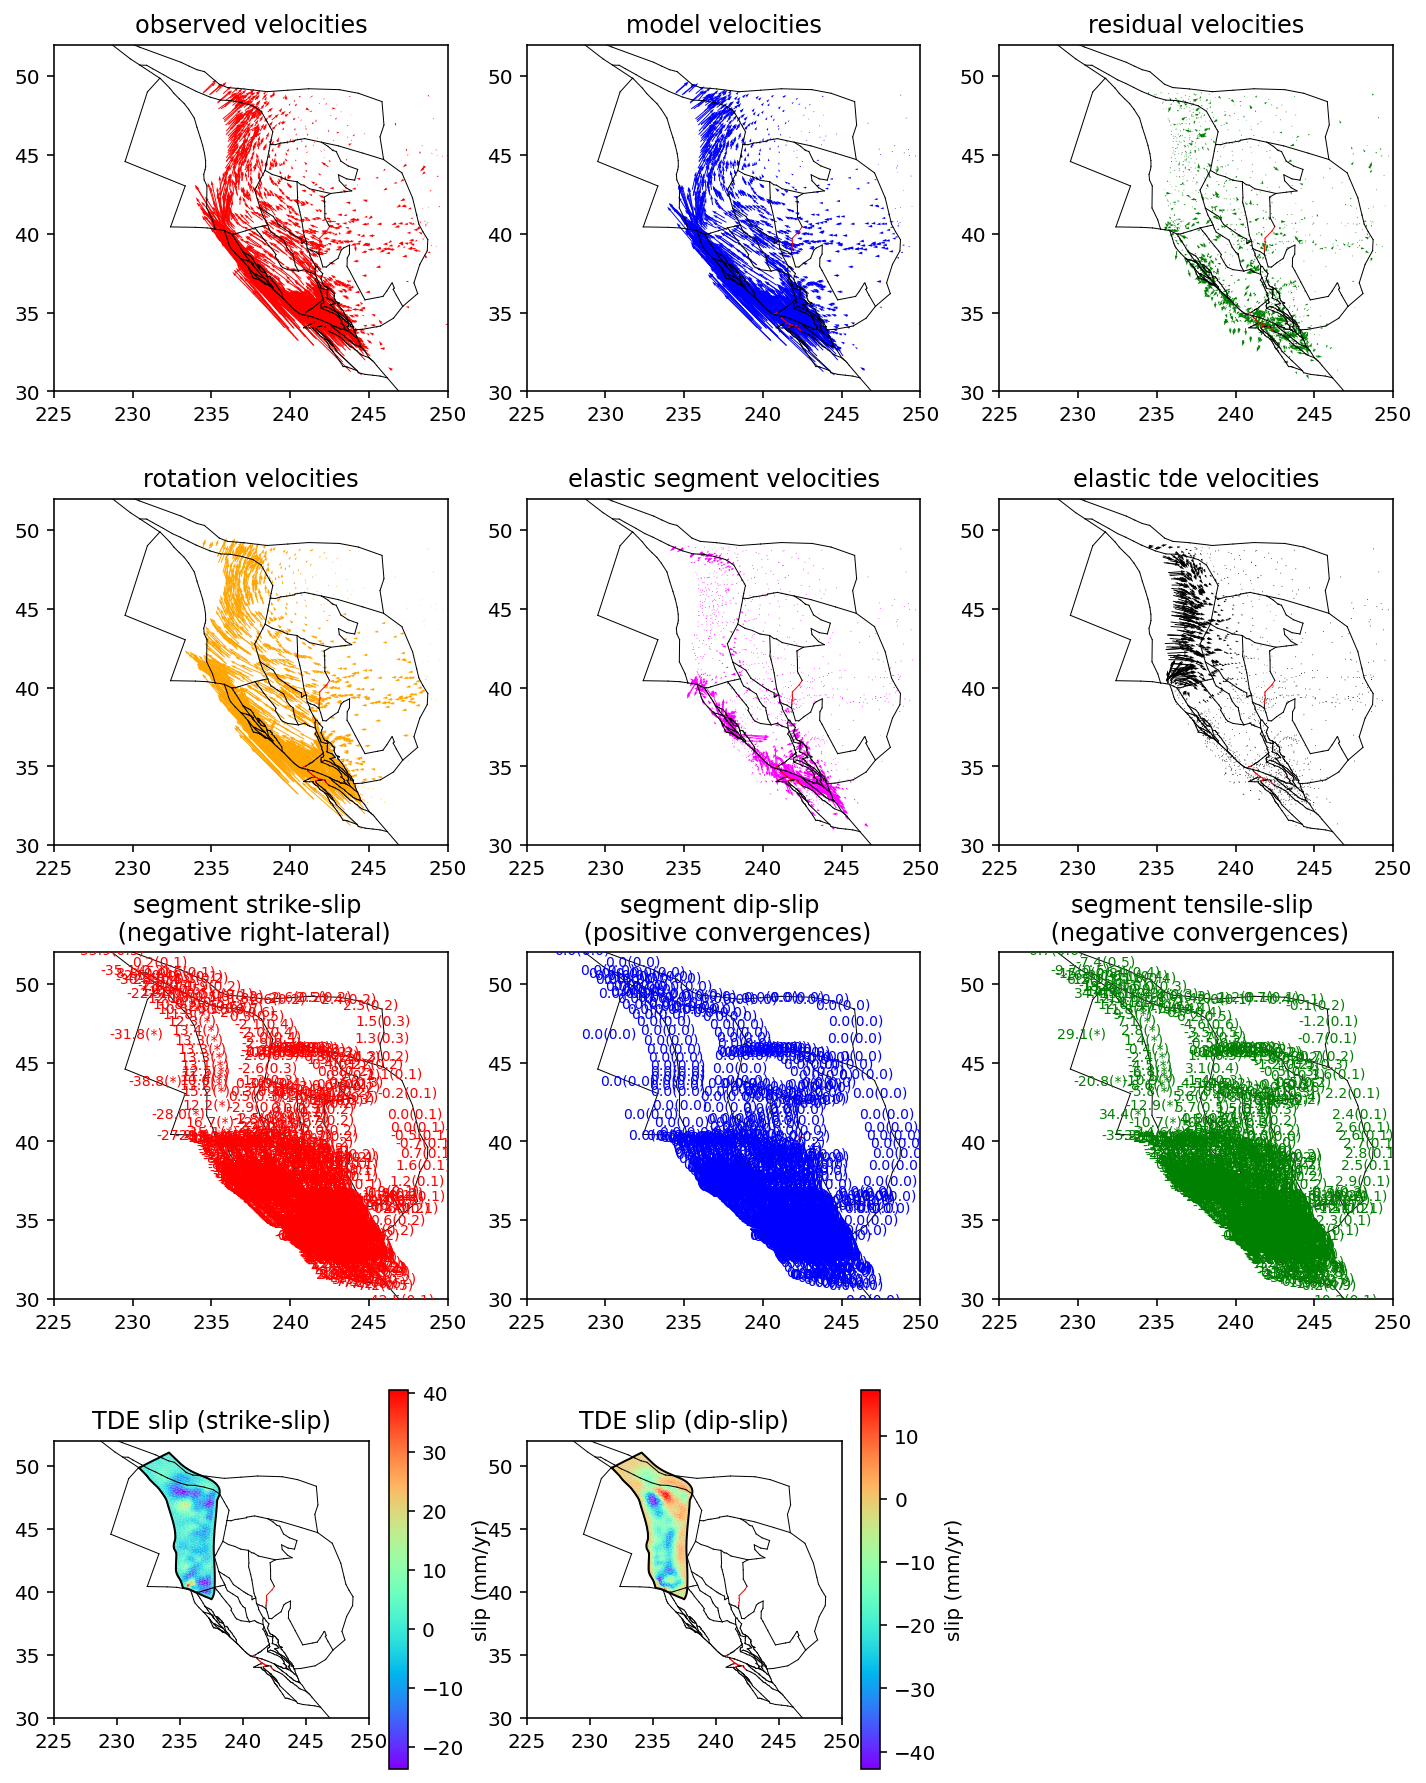

In [8]:
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(225, 250), lat_range=(30, 52), quiver_scale=1e2)

# Try iterative solve on full system cast to sparse - Runs and block motions look fine but TDEs are way off.

In [9]:
import pickle
with open('dev_data.pkl', 'wb') as f:
   pickle.dump([estimation, operators, meshes, segment, station, command], f)

In [10]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import lsmr

estimation.operator_sparse = csr_matrix(estimation.operator * np.sqrt(estimation.weighting_vector[:, None]))
# %time estimation.state_vector_unweighted_dense = np.linalg.inv(estimation.operator.T @ estimation.operator) @ estimation.operator.T  @ estimation.data_vector
%time estimation.state_vector_weighted_sparse_lsmr = lsmr(estimation.operator_sparse, estimation.data_vector * np.sqrt(estimation.weighting_vector))

# For weighted least squares look at:
# https://stackoverflow.com/questions/24979712/python-method-for-solving-a-weighted-least-squares-with-non-diagonal-weight-matr

CPU times: user 7.95 s, sys: 56.2 ms, total: 8.01 s
Wall time: 8.02 s


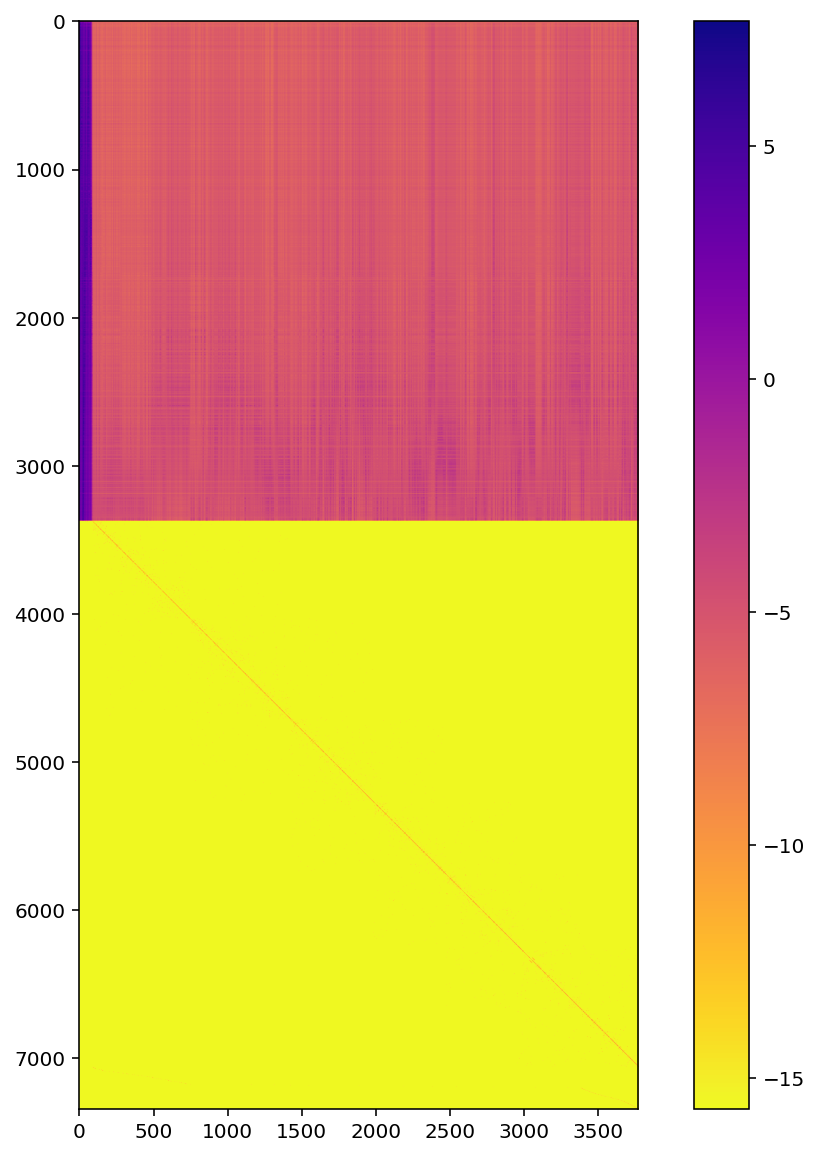

In [11]:
celeri.celeri_vis.plot_matrix_abs_log(csr_matrix.todense(estimation.operator_sparse))

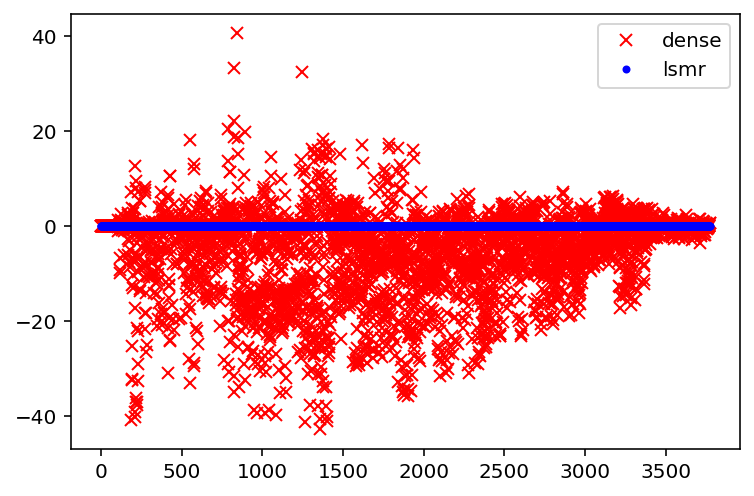

In [12]:
plt.figure()
plt.plot(estimation.state_vector, "rx", label="dense")
plt.plot(estimation.state_vector_weighted_sparse_lsmr[0], "b.", label="lsmr")
plt.legend()
plt.show()

# Plot classical dense model results

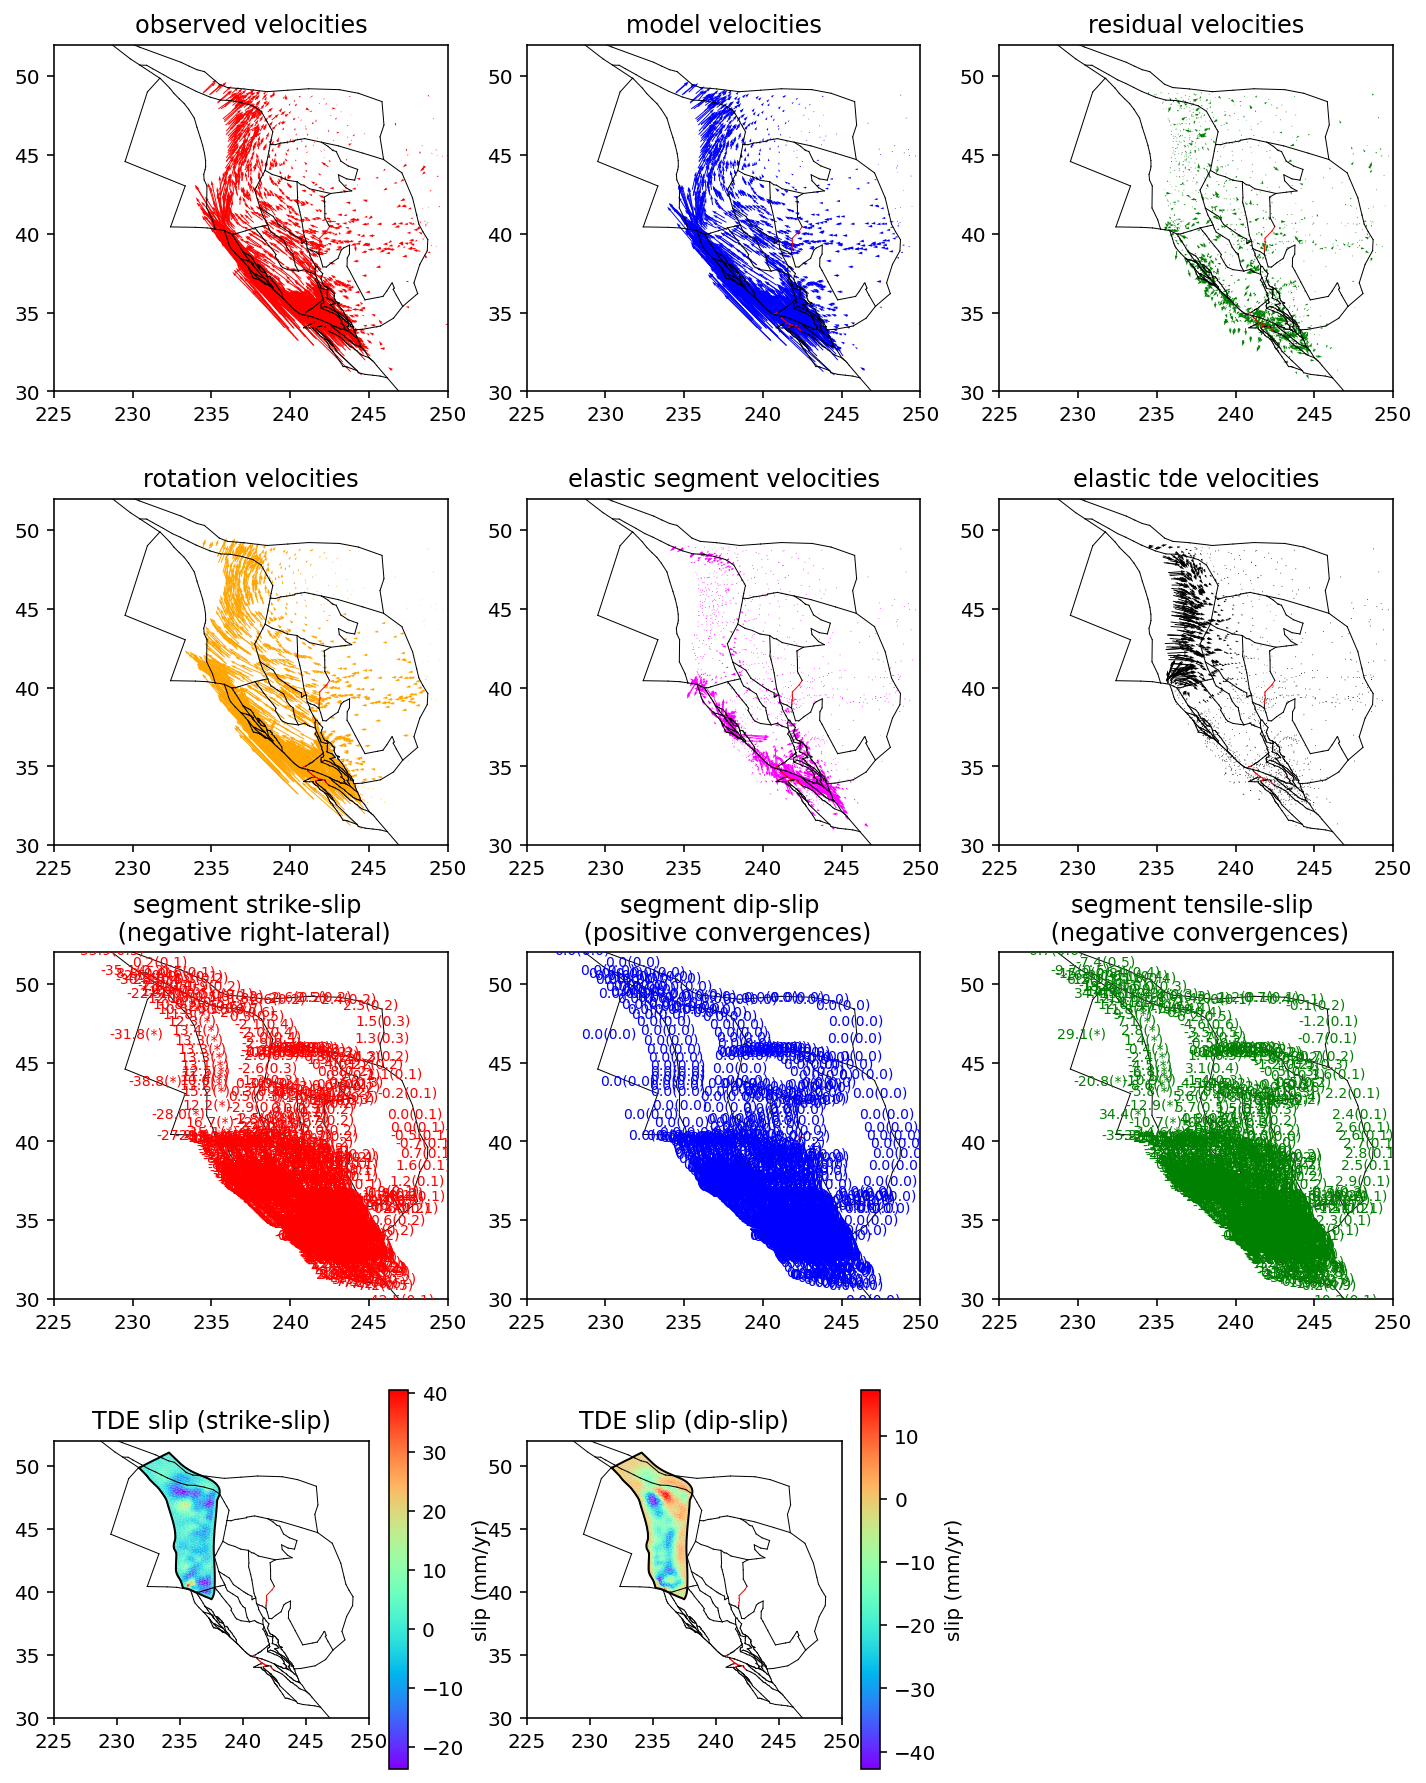

In [13]:
celeri.post_process_estimation(estimation, operators, station, index)
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(225, 250), lat_range=(30, 52), quiver_scale=1e2)

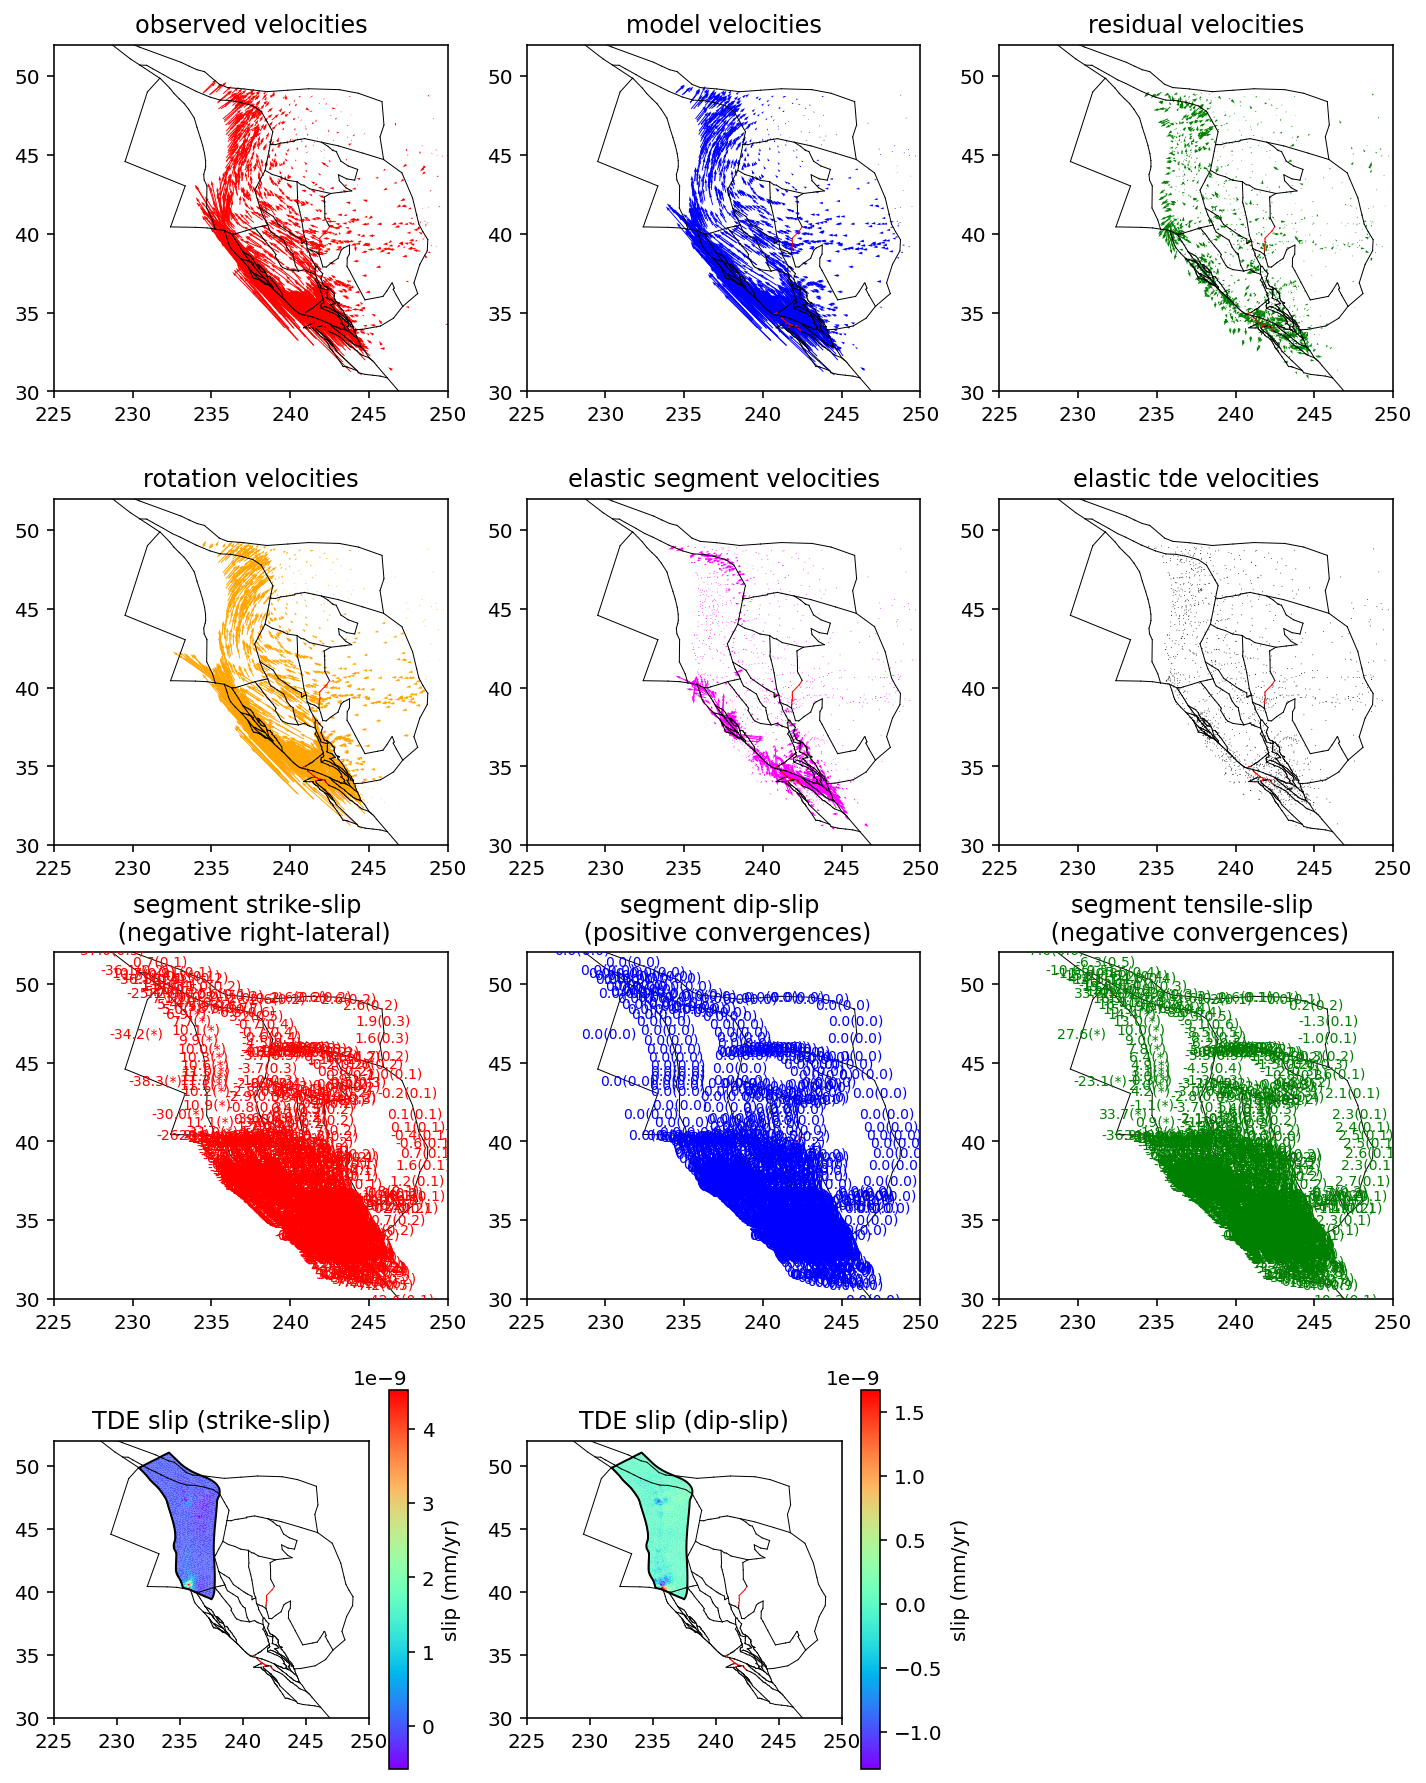

In [14]:
estimation.state_vector = estimation.state_vector_weighted_sparse_lsmr[0]
celeri.post_process_estimation(estimation, operators, station, index)
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(225, 250), lat_range=(30, 52), quiver_scale=1e2)

# Sketching out the assembly of the block model system for the sparse + H-matrix case

### The linear system - conceptual
$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints}
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} \\
    \mathrm{identities}                                          & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} \\
    0                                                            & \mathrm{identities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
\end{bmatrix}
$$


### The linear system - sparse and dense
$$
\begin{bmatrix}
    \mathrm{data \; vector}
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{dense \; but \; cast \; to \; sparse} & \mathrm{Hmatrix \; part} \\
    \mathrm{sparse}                                          & 0 \\
    \mathrm{sparse}           & 0 \\
    0                                                            & \mathrm{sparse} \\
    0                                                            & \mathrm{sparse}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{state \; vector}
\end{bmatrix}
$$

### The linear system - variable names
$$
\begin{bmatrix}
    \texttt{data\_vector}
\end{bmatrix}
=
\begin{bmatrix}
    \texttt{sparse\_block\_motion\_okada\_faults} & \texttt{TBD} \\
    \texttt{sparse\_block\_motion\_constraints}                                          & \texttt{0} \\
    \texttt{sparse\_block\_slip\_rate\_constraints}           & \texttt{0} \\
    \texttt{0}                                                            & \texttt{sparse\_tde\_smoothing} \\
    \texttt{0}                                                            & \texttt{sparse\_tde\_slip\_rate\_constraints}
\end{bmatrix}
\begin{bmatrix}
    \texttt{state\_vector}
\end{bmatrix}
$$

This is all weighted with $\texttt{weighting\_matrix}$.

In [15]:
# Make the sparse matrices and give clean names to variables
data_vector = estimation.data_vector
weighting_vector = estimation.weighting_vector
sparse_block_motion_okada_faults = csr_matrix(operators.rotation_to_velocities[index.station_row_keep_index, :] - operators.rotation_to_slip_rate_to_okada_to_velocities[index.station_row_keep_index, :])
sparse_block_motion_constraints = csr_matrix(operators.block_motion_constraints)
sparse_block_slip_rate_constraints = csr_matrix(operators.slip_rate_constraints)
sparse_tde_smoothing = csr_matrix(operators.meshes[0].smoothing_matrix[smoothing_keep_index, :][:, smoothing_keep_index])
sparse_tde_slip_rate_constraints = csr_matrix(operators.meshes[0].tde_slip_rate_constraints)
tde_matrix = estimation.operator[index.start_station_row:index.end_station_row, index.meshes[0].start_tde_col:index.meshes[0].end_tde_col]

# Start of H-matrix part for TDE slip to velocities

In [16]:
import celeri.hmat_tree as tree

ModuleNotFoundError: No module named 'celeri.hmat_tree'

In [ ]:
tri_centers = meshes[0].centroids.copy()
tri_pts = np.transpose(np.array([
    [meshes[0].lon1, meshes[0].lon2, meshes[0].lon3],
    [meshes[0].lat1, meshes[0].lat2, meshes[0].lat3],
    [meshes[0].dep1, meshes[0].dep2, meshes[0].dep3]
]), (2, 1, 0))
obs_pts = np.array([station.lon, station.lat, 0*station.lat]).T.copy()

In [ ]:
# Scale the x and y coords so that they're approximately in terms of kms like
# the z coord
for arr in [tri_centers, tri_pts, obs_pts]:
    arr[..., 0] *= 85 # appx at 40 degrees north
    arr[..., 1] *= 111 # appx at 40 degrees north

# Check the average triangle length scale in x, y, z directions.
np.mean(np.linalg.norm(tri_pts - tri_centers[:, None, :], axis=2), axis=0)

# Check the average triangle length scale in x, y, z directions.
tri_radii = np.min(np.linalg.norm(tri_pts - tri_centers[:, None, :], axis=2), axis=1)

obs_tree = tree.build_tree(obs_pts, 0*obs_pts[:,0], min_pts_per_box=20)
src_tree = tree.build_tree(tri_centers, tri_radii, min_pts_per_box=20)
direct_pairs, approx_pairs = tree.traverse(obs_tree.root, src_tree.root)
print(len(direct_pairs), len(approx_pairs))

simple_entries = 0
h_entries = 0
n_src = tri_centers.shape[0]
n_obs =  obs_pts.shape[0]
tde_reshaped = tde_matrix.reshape((n_obs, 2, n_src, 2))
for obs_node, src_node in approx_pairs:#[:10]:
    obs_idxs = obs_tree.ordered_idxs[obs_node.idx_start:obs_node.idx_end]
    src_idxs = src_tree.ordered_idxs[src_node.idx_start:src_node.idx_end]
    h_block = tde_reshaped[obs_idxs,:][:,:,src_idxs]
    h_block = h_block.reshape((h_block.shape[0] * 2, -1))
    # print(block.shape)
    U, S, V = np.linalg.svd(h_block)
    tol = 1e-4 * (h_block.size / tde_matrix.size)
    frob_K = np.sqrt(np.cumsum(S[::-1] ** 2))[::-1]
    appx_rank = np.argmax(frob_K < tol)
    # appx_rank = np.argmax(S < tol)
    simple_entries += h_block.size
    h_entries += h_block.shape[0] * appx_rank + appx_rank * h_block.shape[1]
print(h_entries / simple_entries)

direct_entries = 0
for obs_node, src_node in direct_pairs:
    h_block = tde_matrix[obs_tree.ordered_idxs[obs_node.idx_start:obs_node.idx_end],:][:,src_tree.ordered_idxs[src_node.idx_start:src_node.idx_end]]
    direct_entries += h_block.size
print((h_entries) / simple_entries, direct_entries/simple_entries)

tree_obs = obs_pts[obs_tree.ordered_idxs]
tree_src = tri_centers[src_tree.ordered_idxs]
print(tde_matrix)

In [ ]:
h_entries